In [1]:
import numpy as np
import stim
from tqdm import tqdm
from cx_list_from_stabilizers_in_sequence import StabilizerCode
from interactive_cx_list_optimizer import InteractiveCxListOptimizer
import cProfile

from quits.qldpc_code import *
from quits.circuit import get_qldpc_mem_circuit
from quits.decoder import sliding_window_bposd_circuit_mem
from quits.simulation import get_stim_mem_result

In [2]:
lift_size, factor = 15, 3   
p1 = [0, 1, 5]    # e + x + x^5
p2 = [0, 2, 7]    # e + x^2 + x^7

In [3]:
code = BpcCode(p1, p2, lift_size, factor)  # Define the BpcCode object
code.build_graph(seed=1)                   # Build the Tanner graph and assign directions to its edges. 

num_zcheck, num_data = code.hz.shape
num_xcheck, num_data = code.hx.shape
num_logical = code.lz.shape[0]
depth = sum(list(code.num_colors.values())) 
print('# data qubits: ', num_data, ' # logical qubits: ', num_logical)
print('# z-check qubits: ', num_zcheck, ' # x-check qubits: ', num_xcheck)
print('# layers of entangling gates: ', depth)

# data qubits:  90  # logical qubits:  8
# z-check qubits:  45  # x-check qubits:  45
# layers of entangling gates:  8


In [4]:
p = 2e-3           # physical error rate
num_rounds = 15    # number of rounds (T-1)
basis = 'Z'        # 'Z' or 'X'

circuit = stim.Circuit(get_qldpc_mem_circuit(code, p, p, p, p, num_rounds, basis=basis))

In [5]:
num_trials = 100
# Simulate the circuit using Stim. 
detection_events, observable_flips = get_stim_mem_result(circuit, num_trials, seed=1)   # simulate the circuit using Stim

W, F = 5, 3                     # sliding window parameters
max_iter, osd_order = 20, 10    # BP-OSD decoder parameters 

# Perform decoding of the detection_events generated from simulating the circuit. 
# Returns the logical observable flip predicted from decoding. 
logical_pred = sliding_window_bposd_circuit_mem(detection_events, circuit, code.hz, code.lz,\
                                                W, F, max_iter=max_iter, osd_order=osd_order, tqdm_on=True)

# Logical error is recorded whenever logical_pred does not match observable_flips for any logical qubit at any round
pL = np.sum((observable_flips- logical_pred).any(axis=1)) / num_trials
lfr = 1 - (1-pL)**(1/num_rounds)
print('p: %.7f, LFR: %.7f'%(p, lfr))

100%|██████████| 100/100 [00:10<00:00,  9.40it/s]

p: 0.0020000, LFR: 0.0006698


In [6]:
stabilizer_x = []
for i in range(code.hx.shape[0]):
    row = []
    for j in range(code.hx.shape[1]):
        if code.hx[i,j] == 1:
            row.append(j)
    stabilizer_x.append(row)
    
stabilizer_z = []
for i in range(code.hz.shape[0]):
    row = []
    for j in range(code.hz.shape[1]):
        if code.hz[i,j] == 1:
            row.append(j)
    stabilizer_z.append(row)

bpc_code = StabilizerCode(stabilizer_x, stabilizer_z, code.lx, code.lz)
cx_list = bpc_code.generate_cx_list()
ancilla_type, data_mapping, ancilla_mapping = bpc_code.build_mappings()


In [7]:
new_ancilla_mapping = {'Z'+str(i): q for i, q in enumerate(code.zcheck_qubits)}
new_ancilla_mapping.update({'X'+str(i): q for i, q in enumerate(code.xcheck_qubits)})
new_ancilla_type = {name: 'X' if name[0] == 'X' else 'Z' for name in new_ancilla_mapping.keys()}
new_data_mapping = {q: q for q in set(code.all_qubits) - set(new_ancilla_mapping.values())}

In [8]:
new_cx_list = []
directions = list(code.direction_inds.keys())
for direction_ind in range(len(directions)):
    direction = directions[direction_ind]
    for color in range(code.num_colors[direction]):
        edges = code.colored_edges[direction_ind][color]
        new_cx_list.extend(list(zip(edges[::2], edges[1::2])))

In [9]:
all_qubits_ids_to_names = {}
for name, q in new_ancilla_mapping.items():
    all_qubits_ids_to_names[q] = name
for name, q in new_data_mapping.items():
    all_qubits_ids_to_names[q] = name

In [10]:
# map qubit indices to ancilla names or data names in the cx_list
for i in range(len(new_cx_list)):
    q1, q2 = new_cx_list[i]
    new_cx_list[i] = (all_qubits_ids_to_names[q1], all_qubits_ids_to_names[q2])
    # change the order so that the data qubit is always the first one
    if new_cx_list[i][0] in new_ancilla_mapping:
        assert new_cx_list[i][1] in new_data_mapping
        new_cx_list[i] = (new_cx_list[i][1], new_cx_list[i][0])
    else:
        assert new_cx_list[i][1] in new_ancilla_mapping

In [11]:
p_cx = 2e-4
p_idle = 0

In [12]:
optimizer = InteractiveCxListOptimizer(
    initial_cx_list=cx_list,
    ancilla_type=ancilla_type,
    data_mapping=data_mapping,
    ancilla_mapping=ancilla_mapping,
    lz=code.lz,
    lx=code.lx,
    experiment_type='both',
    p_cx=p_cx,
    p_idle=p_idle,
    cycles_with_noise=15,
)

In [13]:
# optimizer = InteractiveCxListOptimizer(
#     initial_cx_list=new_cx_list,
#     ancilla_type=new_ancilla_type,
#     data_mapping=new_data_mapping,
#     ancilla_mapping=new_ancilla_mapping,
#     lz=code.lz,
#     lx=code.lx,
#     experiment_type='both',
#     p_cx=p_cx,
#     p_idle=p_idle,
#     cycles_with_noise=15,
# )

In [ ]:
def test():
    optimizer.run_optimization(
        max_bp_iterations=20,
        osd_order=10,
        iterations=2,
        max_num_shots=100,
        max_num_errors=20,
        step_type='single_stabilizer',
        flags=False,
    )

%prun test()

Total idling time: 0
90
270
Total idling time: 0
90
270
Changed: (9, 'X9') -> (54, 'X9')
Changed: (46, 'X9') -> (9, 'X9')
Changed: (54, 'X9') -> (56, 'X9')
Changed: (56, 'X9') -> (46, 'X9')
Total idling time: 0
90
270
Total idling time: 0
90
270
Iteration 0: improved objective to 0.0
Changed: (6, 'X39') -> (39, 'X39')
Changed: (24, 'X39') -> (76, 'X39')
Changed: (39, 'X39') -> (84, 'X39')
Changed: (76, 'X39') -> (6, 'X39')
Changed: (84, 'X39') -> (24, 'X39')
Total idling time: 0
90
270
Total idling time: 0
90
270
Changed: (7, 'X22') -> (31, 'X22')
Changed: (22, 'X22') -> (67, 'X22')
Changed: (31, 'X22') -> (22, 'X22')
Changed: (67, 'X22') -> (74, 'X22')
Changed: (74, 'X22') -> (7, 'X22')
Total idling time: 0
90
270
Total idling time: 0
90
270


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/__init__.py", line 16, in <module>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1140, in _find_and_load_unlocked
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
ModuleNotFoundError  File "<string>", line 1, in <module>
: No module named 'msvcrt'  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main

Traceback (most recent call last):
  File "<string>", line 1, in <module>

      File "<string>", line 1, in <module>
from . import context
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Pyth

AttributeError: 'NoneType' object has no attribute 'kill'

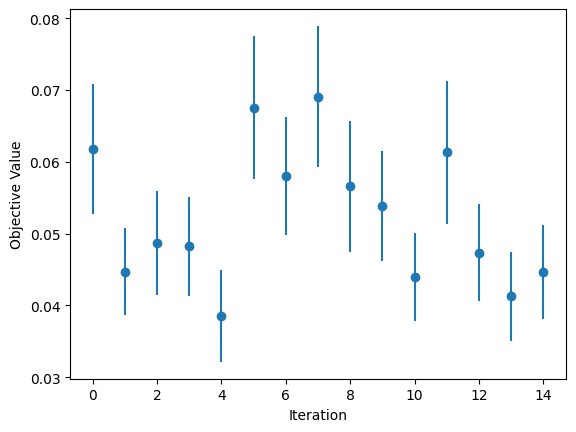

In [ ]:
optimizer.plot_history()

In [ ]:
# use for loop!!!